<a href="https://colab.research.google.com/github/shufan6011/Astrophys-and-AI-Res/blob/main/Step_10_RFs_for_GW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Update:
# Use GPU instead of CPU for faster model training

# Data Preprocessing & functions

In [ ]:
import numpy as np
import pandas as pd
import requests, os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Go to https://gwosc.org
# Find info required below (GPS time & detector)


In [ ]:
# Set GPS time:
t_start = 1126259462.4
t_end = 1126259462.4 # For specific events, make t_end the same as t_start

# Choose detector (H1, L1, or V1)
detector = 'H1'


In [ ]:
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy==3.0.8"
    ! pip install -q "matplotlib==3.9.0"
    ! pip install -q "astropy==6.1.0"
    from gwpy.timeseries import TimeSeries


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.8 MB/s eta 0:00:00


In [ ]:
from gwosc.locate import get_urls
url = get_urls(detector, t_start, t_end)[-1]

# If an event is chosen, then its info will be shown in url
print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:
    straindata = requests.get(url)
    strainfile.write(straindata.content)


Downloading:  http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [ ]:
# Read strain data
strain = TimeSeries.read(fn,format='hdf5.gwosc')

# Examine an interval closely
# center = int(t_start)
# strain = strain.crop(center-0.2, center+0.1)

# Extract time and strain vals
timestamps = strain.times.value
strain_values = strain.value

# Store data in pd df
data = pd.DataFrame({
    'time': timestamps,
    'strain': strain_values
})


## Handling Missing Values

In [ ]:
# Drop rows with missing vals
data = data.dropna()

print("\nMissing vals after cleaning:")
print(data.isnull().sum())



Missing vals after cleaning:
time      0
strain    0
dtype: int64


## Data Noise Filtering

In [ ]:
# Band-pass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter params
lowcut = 20  # Low cutoff frequency (Hz)
highcut = 500  # High cutoff frequency (Hz)

# Band-pass filter strain data
data['strain'] = bandpass_filter(data['strain'], lowcut, highcut, 4096)


## Data Normalization

In [ ]:
# Normalize strain data
scaler = StandardScaler()
data['strain'] = scaler.fit_transform(data[['strain']])


## Data Inspection

In [ ]:
# Inspect first few rows
print("First few rows of data:")
print(data.head())

# Inspect col headers
print("\nCol headers:")
print(data.columns)

# Summary stats
print("\nSummary stats:")
print(data.describe())

# Check for missing vals
print("\nMissing vals in each col:")
print(data.isnull().sum())

# Check sampling frequency
print(f"\nSampling frequency: {strain.sample_rate} Hz")
fs = 4096 # Change this if sampling frequency is different

# Redef original strain w/ preprocessed data
strain = TimeSeries(data['strain'].values, times=timestamps, sample_rate=fs)


First few rows of data:
           time    strain
0  1.126257e+09 -2.509170
1  1.126257e+09  0.070279
2  1.126257e+09  2.209691
3  1.126257e+09  3.618610
4  1.126257e+09  4.256309

Col headers:
Index(['time', 'strain'], dtype='object')

Summary stats:
               time        strain
count  1.677722e+07  1.677722e+07
mean   1.126259e+09 -1.758737e-17
std    1.182413e+03  1.000000e+00
min    1.126257e+09 -3.686864e+00
25%    1.126258e+09 -7.088868e-01
50%    1.126259e+09  1.167451e-03
75%    1.126260e+09  7.087773e-01
max    1.126262e+09  4.284804e+00

Missing vals in each col:
time      0
strain    0
dtype: int64

Sampling frequency: 4096.0 Hz Hz


## Data Augmentation

In [ ]:
def augment_data(data, labels):
    augmented_data = []
    augmented_labels = []
    for d, l in zip(data, labels):
        augmented_data.append(d)
        augmented_labels.append(l)
        augmented_data.append(np.flip(d, axis=0))
        augmented_labels.append(l)
        noise = np.random.normal(0, 0.1, d.shape)
        augmented_data.append(d + noise)
        augmented_labels.append(l)
    return np.array(augmented_data), np.array(augmented_labels)


## Data Segmenting & Labeling

In [ ]:
def create_segments_and_labels(strain, event_time, window_size, sample_rate):
    # Resample strain to desired sample rate (if necessary)
    strain = strain.resample(sample_rate)

    # Def segments and labels ls
    segments = []
    labels = []

    # Calc # of samples per segment
    segment_length = int(window_size * sample_rate)

    # Create segments and labels
    for i in range(0, len(strain) - segment_length, segment_length):
        segment = strain[i:i + segment_length]
        segments.append(segment.value)

        # Label based on event presence
        if segment.times.value[0] <= event_time <= segment.times.value[-1]:
            labels.append(1)  # Event present
        else:
            labels.append(0)  # No event

    # Convert to np arrays
    segments = np.array(segments)
    labels = np.array(labels)

    print(f"Segments shape: {segments.shape}")
    print(f"Labels shape: {labels.shape}")

    # Verify segments
    print("First few segments:")
    print(segments[:2])

    return segments, labels


## Final Product

In [ ]:
def save_model(model_filename):
    # Save model
    joblib.dump(model, model_filename)
    print(f"Model saved as {model_filename}")

# RF

## Segments Labeling

In [ ]:
segments, labels = create_segments_and_labels(strain, t_start, 2, fs)


Segments shape: (2047, 8192)
Labels shape: (2047,)
First few segments:
[[-2.50916966  0.0702791   2.20969137 ...  0.5505348
   0.68438925  0.80870373]
 [ 0.77395483  0.49010925 -0.00384874 ...  0.42781003
   0.39635154  0.19273885]]


## Data Preparation (time-series data)

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=42)

## Data Augmentation

In [ ]:
X_train_aug, y_train_aug = augment_data(X_train, y_train)

print(f"Original training data shape: {X_train.shape}")
print(f"Augmented training data shape: {X_train_aug.shape}")


Original training data shape: (1637, 8192)
Augmented training data shape: (4911, 8192)


## Model Training

In [ ]:
# Def rf
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
model.fit(X_train, y_train)

# Make pred
y_pred = model.predict(X_test)

# Evaluate model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410

    accuracy                           1.00       410
   macro avg       1.00      1.00      1.00       410
weighted avg       1.00      1.00      1.00       410

[[410]]


## Model Evaluation

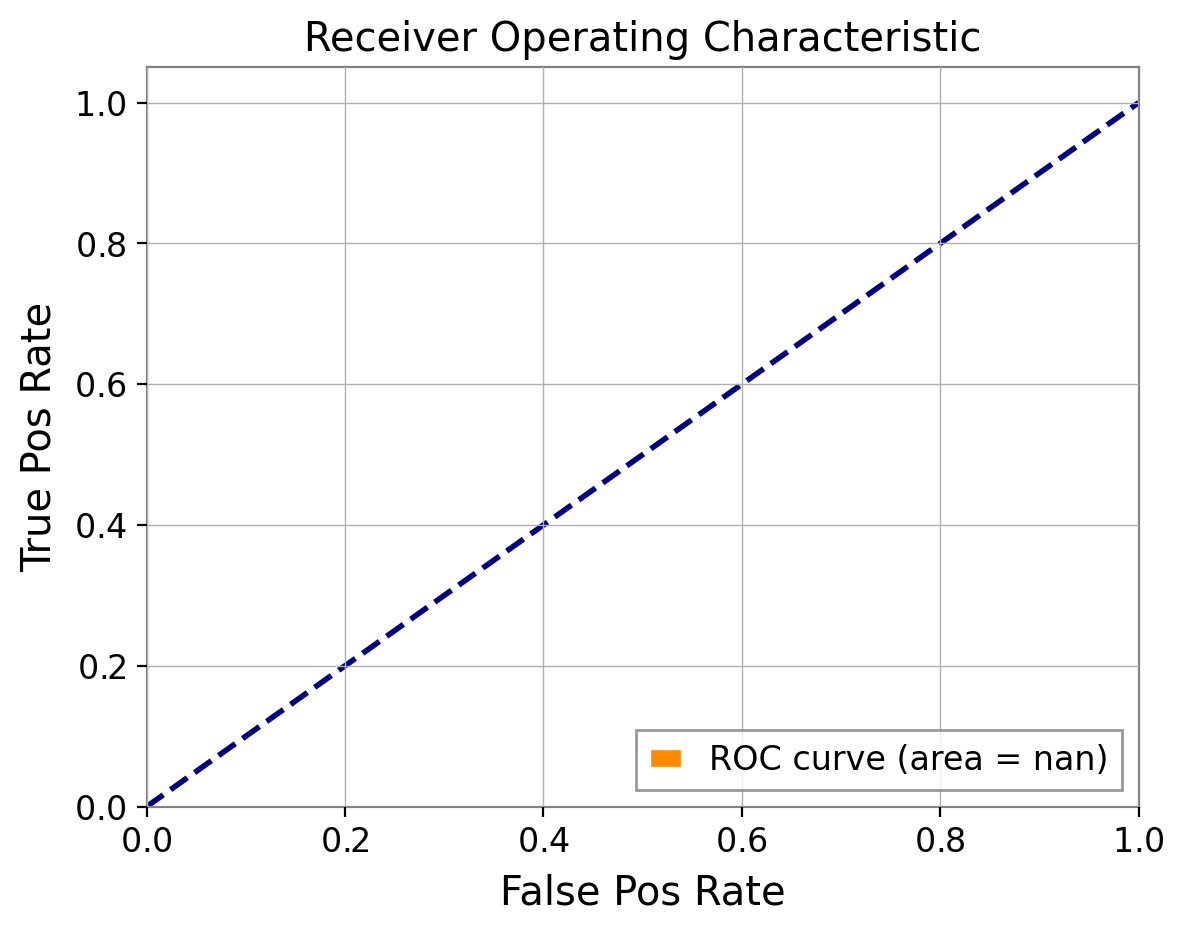

In [ ]:
# Compute ROC curve & area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot result
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Final Product

In [ ]:
save_model('gw_rf.pkl')


Model saved as gw_rf.pkl
